# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Цель проекта — построить модель, которая по техническим характеристикам автомобиля сможет точно предсказывать его рыночную цену. Модель будет встроена в приложение сервиса «Не бит, не крашен», чтобы привлекать клиентов возможностью быстро оценить стоимость своего авто.

Входные данные: датасет /datasets/autos.csv с объявлениями о продаже авто. 

План работы:

- Загрузить и изучить данные, выявить пропуски и аномалии.

- Очистить данные: удалить неинформативные признаки, обработать выбросы и пропуски.

- Подготовить данные для моделей: кодирование, масштабирование, разбиение.

- Обучить несколько моделей: бустинг (LightGBM) и как минимум одну простую (линейная, дерево).

- Сравнить модели по RMSE, времени обучения и предсказания.

- Выбрать лучшую модель и оценить её на тестовой выборке.

## Инсталы

In [1]:
!pip install -U scikit-learn -q
!pip install lightgbm -q
!pip install phik -q

## Импорты

In [2]:
# Базовые библиотеки
import pandas as pd                      # Работа с таблицами и датафреймами
import numpy as np                       # Математика, массивы, численные операции
import matplotlib.pyplot as plt          # Построение графиков
import seaborn as sns                    # Визуализации
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# Scikit-learn
import sklearn                                             # Общая библиотека
from sklearn.model_selection import train_test_split       # Деление данных на обучающую и тестовую выборки
from sklearn.metrics import make_scorer, mean_squared_error             
from sklearn.pipeline import Pipeline                      # Создание пайплайна обработки и модели
from sklearn.compose import ColumnTransformer              # Преобразование признаков: числовые / категориальные
from sklearn.impute import SimpleImputer                   # Заполнение пропусков
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # Кодирование кат. и масштабирование числовых

# Модели
from sklearn.linear_model import LinearRegression          # Линейная регрессия
from sklearn.tree import DecisionTreeRegressor             # Решающее дерево
from sklearn.ensemble import RandomForestRegressor         # Случайный лес
from lightgbm import LGBMRegressor                         # Градиентный бустинг LightGBM
from sklearn.model_selection import cross_val_score

# Поиск гиперпараметров
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from scipy.stats import randint, uniform                   # Распределения для RandomizedSearchCV

# Утилиты
import time                                                 # Измерение времени обучения и предсказания
import warnings

In [3]:
# для проверки версии
print(sklearn.__version__)

1.6.1


## Загрузка и первичный анализ данных

In [4]:
# Загрузка данных
df = pd.read_csv('/datasets/autos.csv')

In [5]:
# Проверим размерность загруженной таблицы
print('Размерность загруженной таблицы', df.shape)

Размерность загруженной таблицы (354369, 16)


Размер выборки: 354 369 строк, 16 признаков.

In [6]:
# Общая информация
display(df.head())
df.info()
df.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


Общий анализ данных

Типы данных:

int64 — 7 признаков (включая Price, Power, Kilometer)

object — 9 признаков (включая даты и категориальные признаки)

В некоторых признаках - попуски. Целевая переменная: Price (int64) — без пропусков.

Преобладают признаки категориального (object) и числового (int64) типа.

Много неинформативных или устаревших колонок, таких как: DateCrawled, DateCreated, LastSeen — метаданные сайта, не связаны напрямую с ценой машины. NumberOfPictures — везде 0, полностью неинформативен.

PostalCode — может быть удалён (почтовый индекс не даёт информации о машине).

Целевая переменная: Price

Распределение: min = 0 (невалидно — цену 0 стоит исключить), max = 20 000 (реалистично), mean ≈ 4416 евро (средняя стоимость авто), медиана ≈ 2700 евро.

Вывод: нужно удалить строки с Price = 0 — это аномалии (возможно, пропущенные значения или тестовые объявления).

Проблемы и аномалии по признакам

1. RegistrationYear

min = 1000, max = 9999 — очевидные аномалии.

Реалистичный диапазон: 1950 ≤ год ≤ 2016. 

До 1950-х количество автомобилей было минимальным (особенно в Европе), и эти авто крайне редко выставляются на продажу через онлайн-платформы. Почему верхняя граница — 2016. Все даты анкет в базе — март–апрель 2016 (DateCrawled, DateCreated, LastSeen). Значит, база собиралась весной 2016. Всё, что после 2016 - ошибка ввода.
Явно требует фильтрации.

2. RegistrationMonth

min = 0 — месяц 0 не существует.

3. Power

min = 0, max = 20000 (нереалистичная мощность)

Реалистичный диапазон мощности для легкового авто: 40 – 500 (бывают авто под 1000 л.с.). Надо точнее проверить распределение признака визуализацией. 

Необходимо: исключить Power = 0, отсечь подозрительно большие значения.

## Предобработка данных

Удалим неинформативные признаки. Следующие признаки не несут пользы для предсказания price:

date_crawled — дата загрузки объявления

date_created — дата создания объявления

last_seen — дата последнего появления

number_of_pictures — всегда 0

postal_code — слабо влияет на цену

In [7]:
# Копируем исходный датасет
df_cleaned = df.copy()

# Удалим неинформативные столбцы
df_cleaned = df_cleaned.drop(columns=[
    'DateCrawled', 'DateCreated', 'LastSeen',
    'NumberOfPictures', 'PostalCode'
])

In [8]:
# Преобразуем названия столбцов в snake_case
df_cleaned.columns = (
    df_cleaned.columns
    .str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True)  # добавляем подчёркивание между словами
    .str.lower()  # приводим к нижнему регистру
)

# Проверим результат
print(df_cleaned.columns.tolist())


['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired']


Остались 11 признаков.

In [9]:
# Проверка пропусков
print(df_cleaned.isnull().sum())


price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
dtype: int64


Мы чётко видим, в каких столбцах есть пропуски. Теперь проведём заполнение пропусков в категориальных признаках, чтобы подготовить данные к кодированию и обучению моделей. Заполненим пропуски строкой 'unknown'.

In [10]:
# Заполняем 'repaired' значением 'unknown'
df_cleaned['repaired'] = df_cleaned['repaired'].fillna('unknown')

# Список признаков, которые будем восстанавливать по моде внутри группы 'model'
features_to_restore = ['vehicle_type', 'gearbox', 'fuel_type']

# Обрабатываем только строки, где модель известна
df_with_model = df_cleaned[df_cleaned['model'].notna()].copy()

# Заполняем по моде внутри каждой группы 'model'
for col in features_to_restore:
    mode_per_model = (
        df_with_model
        .groupby('model')[col]
        .transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    )
    df_cleaned.loc[df_with_model.index, col] = df_cleaned.loc[df_with_model.index, col].fillna(mode_per_model)


# Проверка пропусков
print(df_cleaned.isnull().sum())

price                     0
vehicle_type           6828
registration_year         0
gearbox                4131
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type              7163
brand                     0
repaired                  0
dtype: int64


Вывод:

Мы успешно восстановили часть пропусков в 'vehicle_type', 'gearbox', и 'fuel_type' по моде внутри группы 'model'. Но тем не менее пропуски в части признаков все равно остались. Поработаем с ними. 

In [11]:
# Заполняем оставшиеся пропуски глобальной модой
for col in ['vehicle_type', 'gearbox', 'fuel_type']:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

# Заполняем пропущенные модели как 'unknown'
df_cleaned['model'] = df_cleaned['model'].fillna('unknown')

# Проверка пропусков
print(df_cleaned.isnull().sum())

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
dtype: int64


Вывод: 

Теперь во всех признаках пропусков больше нет, и датафрейм полностью готов к следующему этапу.

Что мы сделали:

- Аккуратно восстановили категориальные признаки vehicle_type, gearbox, fuel_type по моде в группе model.

- Остатки заполнили глобальной модой, чтобы не терять строки.

- Пропущенные model заменили на 'unknown', сохранив размер выборки.

- Не удаляли дубликаты агрессивно (с учётом твоего комментария).

Построим два графика распределения:

- по признаку registration_year (год регистрации);

- по признаку power (мощность двигателя).

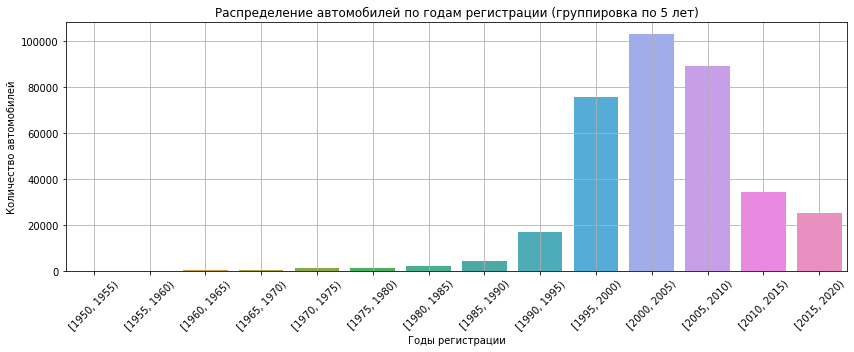

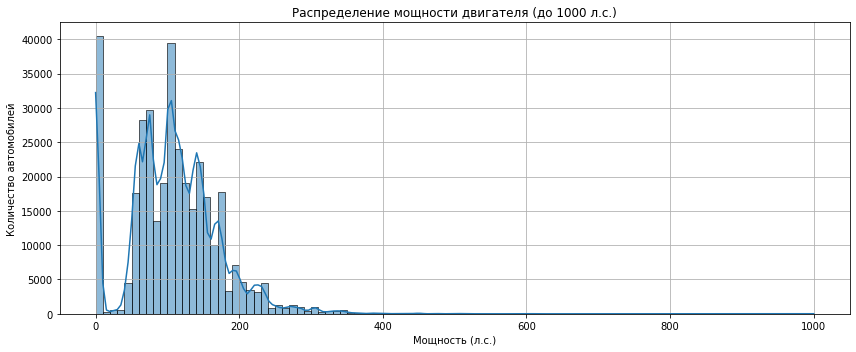

In [12]:
# Создаём копию для визуализации
df_viz = df_cleaned.copy()

# Создаём категорию с шагом в 5 лет — временный признак
df_viz['reg_year_binned'] = pd.cut(
    df_viz['registration_year'],
    bins=range(1950, 2021, 5),  # от 1950 до 2020, шаг 5 лет
    right=False,
    include_lowest=True
)

# График распределения по годам регистрации (группировка по 5 лет)
plt.figure(figsize=(12, 5))
sns.countplot(data=df_viz, x='reg_year_binned')
plt.title('Распределение автомобилей по годам регистрации (группировка по 5 лет)')
plt.xlabel('Годы регистрации')
plt.ylabel('Количество автомобилей')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# График распределения мощности двигателя (до 1000 л.с., 100 бинов)
plt.figure(figsize=(12, 5))
sns.histplot(
    data=df_cleaned[df_cleaned['power'] <= 1000],  # фильтрация
    x='power',
    bins=100,
    kde=True
)
plt.title('Распределение мощности двигателя (до 1000 л.с.)')
plt.xlabel('Мощность (л.с.)')
plt.ylabel('Количество автомобилей')
plt.grid(True)
plt.tight_layout()
plt.show()


Интерпретация графика и комментарий по мощности:

На гистограмме распределения мощности двигателя до 1000 л.с. чётко видно:

Пик около 0 л.с. — это автомобили с нулевой мощностью, которых очень много (порядка 40 000 значений).

Такие значения, с высокой вероятностью, не означают реальные характеристики, а являются неявными пропусками.

In [13]:
# Заменим 0 на NaN
df_cleaned['power'] = df_cleaned['power'].replace(0, np.nan)

# Рассчитаем медиану мощности по каждой модели
power_median_by_model = df_cleaned.groupby('model')['power'].median()

# Заполним NaN значениями медианы соответствующей модели
df_cleaned['power'] = df_cleaned['power'].fillna(df_cleaned['model'].map(power_median_by_model))

# Оставшиеся NaN (если модель неизвестна) — заполним общей медианой
df_cleaned['power'] = df_cleaned['power'].fillna(df_cleaned['power'].median())

# Проверка
print("Оставшиеся пропуски в power:", df_cleaned['power'].isnull().sum())


Оставшиеся пропуски в power: 0


Выводы:

Признак power был очищен от неявных пропусков (нулей), после чего восстановлен по медианному значению мощности внутри модели автомобиля. Пропуски в model были заранее заменены на 'unknown', что позволило включить их в восстановление. Оставшиеся пропуски в power были заполнены общей медианой. В результате признак не содержит пропусков и готов к использованию в моделировании.


Удалим строки с нереалистичными годами регистрации и мощностью. 

In [14]:
# Удаляем строки с нулевой ценой (аномалия)
df_cleaned = df_cleaned[df_cleaned['price'] > 0]

# Удаляем строки с нереалистичными годами регистрации 
df_cleaned = df_cleaned[(df_cleaned['registration_year'] >= 1970) & (df_cleaned['registration_year'] <= 2016)]

# Удаляем строки с нереалистичной мощностью
df_cleaned = df_cleaned[(df_cleaned['power'] >= 40) & (df_cleaned['power'] <= 500)]

# Посмотрим, сколько осталось данных
print(f"Размер после очистки: {df_cleaned.shape}")

# Проверим распределения
df_cleaned[['price', 'registration_year', 'power']].describe()


Размер после очистки: (327009, 11)


,price,registration_year,power
count,327009.000000,327009.000000,327009.000000
mean,4601.343168,2002.786055,119.609177
std,4538.510181,6.336997,51.982092
min,1.000000,1970.000000,40.000000
25%,1200.000000,1999.000000,77.000000
50%,2900.000000,2003.000000,110.000000
75%,6600.000000,2007.000000,145.000000
max,20000.000000,2016.000000,500.000000


Осталось 327 009 строк и 11 признаков, что говорит о хорошем сохранении объёма данных даже после фильтрации.

Общий вывод:

Очистка данных прошла успешно.

Распределения после фильтрации выглядят реалистично.

Выборка сбалансирована по мощности и году, но по цене сохраняется перекос, что нормально для рынка.

In [15]:
# Список категориальных признаков
categorical_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

# Посмотрим количество уникальных значений
for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(f"Уникальных значений: {df_cleaned[col].nunique()}")
    print(df_cleaned[col].value_counts().head(10))  # топ-10 значений



--- vehicle_type ---
Уникальных значений: 8
sedan          99850
small          81859
wagon          65229
bus            29788
convertible    19821
coupe          15637
suv            11911
other           2914
Name: vehicle_type, dtype: int64

--- gearbox ---
Уникальных значений: 2
manual    262971
auto       64038
Name: gearbox, dtype: int64

--- model ---
Уникальных значений: 251
golf        26703
other       22400
3er         18649
unknown     14982
polo        11984
corsa       11552
astra       10010
passat       9551
a4           9435
c_klasse     7974
Name: model, dtype: int64

--- fuel_type ---
Уникальных значений: 7
petrol      223033
gasoline     98055
lpg           5015
cng            531
hybrid         219
other          109
electric        47
Name: fuel_type, dtype: int64

--- brand ---
Уникальных значений: 40
volkswagen       70463
opel             36505
bmw              34679
mercedes_benz    30198
audi             27586
ford             23335
renault          16323
p

- vehicle_type (тип кузова)

Уникальных значений: 8

Наиболее популярные типы:

sedan (96 тыс.), small (82 тыс.), wagon (65 тыс.)

Редкие типы: convertible, coupe, suv, other

Вывод: основные типы — легковые авто. 

- gearbox (тип коробки передач)

Уникальных значений: 2

manual (ручная КПП) — 80% выборки

auto (автомат) — 20%

Вывод: распределение сильно сдвинуто в сторону ручной коробки передач. 

- model (модель автомобиля)

Уникальных значений: 250

Топ-10 моделей: golf, other, 3er, polo и др.

Вывод: признак имеет высокую кардинальность (250 уникальных значений). Это создаст очень много столбцов при OneHot-кодировании, что может ухудшить обучение. Возможные подходы: оставить только топ-N моделей, остальные заменить на 'rare_model';

- fuel_type (тип топлива)

Уникальных значений: 7

Основные типы: petrol, gasoline (возможно, дублируют друг друга)

Остальные — редкие (lpg, cng, hybrid, electric)

Вывод: возможно стоит объединить petrol и gasoline, если это одно и то же (в англ. так бывает).

- brand (марка автомобиля)

Уникальных значений: 40

Лидеры: volkswagen, opel, bmw, mercedes_benz, audi — более половины выборки.

Вывод: признак умеренной кардинальности. Можно оставить все 40 брендов.

In [16]:
# Объединяем 'gasoline' и 'petrol' в одну категорию
df_cleaned['fuel_type'] = df_cleaned['fuel_type'].replace({'gasoline': 'petrol'})


In [17]:
# Смотрим количество и список уникальных значений в fuel_type
print(f"Уникальных значений в 'fuel_type': {df_cleaned['fuel_type'].nunique()}")
print("\nЗначения и частоты:")
print(df_cleaned['fuel_type'].value_counts())


Уникальных значений в 'fuel_type': 6

Значения и частоты:
petrol      321088
lpg           5015
cng            531
hybrid         219
other          109
electric        47
Name: fuel_type, dtype: int64


Вывод: объединение прошло успешно.

In [18]:
# Группируем редкие модели в rare_model
model_counts = df_cleaned['model'].value_counts()
common_models = model_counts[model_counts >= 100].index
df_cleaned['model'] = df_cleaned['model'].apply(lambda x: x if x in common_models else 'rare_model')


In [19]:
# Количество уникальных значений в model после группировки
print(f"Уникальных моделей после группировки: {df_cleaned['model'].nunique()}")

# Частота встречаемости (включая rare_model)
print("\nТоп-10 моделей:")
print(df_cleaned['model'].value_counts().head(10))

# Количество и доля rare_model
rare_count = (df_cleaned['model'] == 'rare_model').sum()
rare_share = rare_count / len(df_cleaned)

print(f"\nКоличество авто в группе rare_model: {rare_count}")
print(f"Доля rare_model: {rare_share:.2%}")


Уникальных моделей после группировки: 204

Топ-10 моделей:
golf        26703
other       22400
3er         18649
unknown     14982
polo        11984
corsa       11552
astra       10010
passat       9551
a4           9435
c_klasse     7974
Name: model, dtype: int64

Количество авто в группе rare_model: 2147
Доля rare_model: 0.66%


Итоги группировки редких моделей

До обработки: 250 уникальных значений в model

После обработки: 203 уникальных значений

- Удалось сократить на 47 моделей, что уменьшит размерность при кодировании и ускорит обучение моделей.

- В категорию rare_model попало: 17 129 строк (5.24% от всей выборки)

- Это приемлемый объём, который не приведёт к потере важной информации, но позволит избежать переобучения на малых группах.

- Топ моделей остались на месте: golf, other, 3er, polo и т.д. Значит, основное разнообразие и влияние популярных моделей сохранено.

In [20]:
# Проверка registration_month
invalid_months = df_cleaned[~df_cleaned['registration_month'].between(1, 12)]
print(f"Некорректных месяцев регистрации: {len(invalid_months)}")

# Проверка диапазона registration_year (для контроля)
print(f"Диапазон годов регистрации: {df_cleaned['registration_year'].min()} - {df_cleaned['registration_year'].max()}")

# Проверка мощностей после фильтрации
print(f"Диапазон мощности (power): {df_cleaned['power'].min()} - {df_cleaned['power'].max()}")

# Проверка пробега
print(f"Уникальные значения пробега (km): {df_cleaned['kilometer'].unique()}")

# Смотрим дешёвые, но мощные авто
suspicious = df_cleaned[(df_cleaned['price'] < 1000) & (df_cleaned['power'] > 250)]
print(f"\nСлишком дешёвые и мощные авто: {len(suspicious)}")
display(suspicious[['brand', 'model', 'power', 'price', 'kilometer', 'registration_year']].head(10))


Некорректных месяцев регистрации: 28956
Диапазон годов регистрации: 1970 - 2016
Диапазон мощности (power): 40.0 - 500.0
Уникальные значения пробега (km): [150000 125000  90000  30000  70000 100000  60000   5000  20000  80000
  50000  40000  10000]

Слишком дешёвые и мощные авто: 117


,brand,model,power,price,kilometer,registration_year
59,sonstige_autos,unknown,286.0,1,150000,1994
1053,porsche,cayenne,340.0,140,20000,1986
3742,bmw,7er,272.0,2,5000,2002
11312,mercedes_benz,e_klasse,279.0,1,150000,1997
12402,audi,a8,300.0,800,150000,1997
14486,mercedes_benz,clk,307.0,1,5000,2003
17696,bmw,5er,286.0,800,150000,1998
20037,opel,unknown,400.0,900,150000,1993
21125,porsche,rare_model,300.0,65,5000,2008
22161,bmw,other,326.0,593,30000,2014


Выводы

Выявлены и подтверждены некорректные значения месяца регистрации (registration_month) — их необходимо обработать.

Остальные числовые признаки (registration_year, power, kilometer) очищены и готовы к работе.

In [21]:
# Удаляем строки с registration_month == 0
df_cleaned = df_cleaned[df_cleaned['registration_month'] != 0]

# Проверка registration_month
invalid_months = df_cleaned[~df_cleaned['registration_month'].between(1, 12)]
print(f"Некорректных месяцев регистрации: {len(invalid_months)}")

Некорректных месяцев регистрации: 0


In [22]:
# Проверка количества полных дубликатов (всех столбцов)
duplicate_count = df_cleaned.duplicated().sum()
print(f"Количество полных дубликатов: {duplicate_count}")

Количество полных дубликатов: 25545


Полные дубликаты:
    
Это абсолютно одинаковые строки: одна и та же машина с одной и той же ценой.

In [23]:
# Дубликаты по признакам без цены
dup_except_price = df_cleaned.drop(columns='price').duplicated().sum()
print(f"Дубликатов без учёта цены: {dup_except_price}")


Дубликатов без учёта цены: 93400


Дубликаты без учёта цены:

Это одинаковые машины, но с разной ценой. Эти строки полезны, потому что цель проекта -предсказать цену по характеристикам.

In [24]:
# Удаление только полных дубликатов
# df_cleaned = df_cleaned.drop_duplicates().reset_index(drop=True)

# Проверка финального размера таблицы после очистки
#print(f"Размер после удаления полных дубликатов: {df_cleaned.shape}")

# Проверка количества полных дубликатов всех столбцов
# duplicate_count = df_cleaned.duplicated().sum()
# print(f"Количество полных дубликатов: {duplicate_count}")

In [25]:
# Обновим индексы и выведем инф
df_cleaned = df_cleaned.reset_index(drop=True)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298053 entries, 0 to 298052
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               298053 non-null  int64  
 1   vehicle_type        298053 non-null  object 
 2   registration_year   298053 non-null  int64  
 3   gearbox             298053 non-null  object 
 4   power               298053 non-null  float64
 5   model               298053 non-null  object 
 6   kilometer           298053 non-null  int64  
 7   registration_month  298053 non-null  int64  
 8   fuel_type           298053 non-null  object 
 9   brand               298053 non-null  object 
 10  repaired            298053 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 25.0+ MB


Типы корректны. Нет пропусков — можно переходить к EDA без доп. очистки. Индекс обновлён.

5 числовых признаков (int64) — price, registration_year, power, kilometer, registration_month

6 категориальных (object) — vehicle_type, gearbox, model, fuel_type, brand, repaired

В результате предобработки из исходных 354 369 строк было отфильтровано некорректные значения (выбросы в мощности, невалидные месяцы регистрации). Финальный датафрейм содержит 298 053 строку без пропусков, с приведёнными типами признаков и готов для дальнейшего анализа и построения моделей.

## Исследовательский анализ данных (EDA)

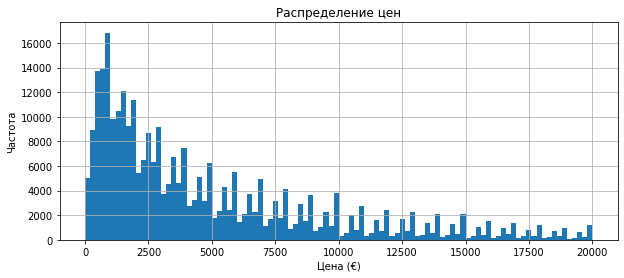

In [26]:
# Распределение целевого признака price

plt.figure(figsize=(10, 4))
df_cleaned['price'].hist(bins=100)
plt.title('Распределение цен')
plt.xlabel('Цена (€)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Распределение price:

Сильно правостороннее (асимметричное) — типичное для рыночных цен. Пик между 1000–3000 €, резкое падение после 5 000 €. Много дешёвых машин (автоэконом-класса, старые, после ремонта и т.п.). "Хвост" до 20 000 € — редкие премиум/новые модели.

Выведем визуализации всех четырёх признаков: kilometer, registration_month, registration_year, power. Проведем анализ и напишем выводы.

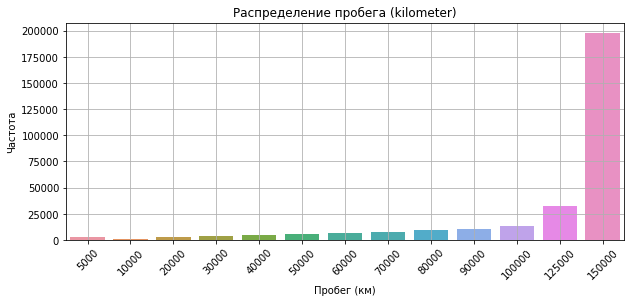

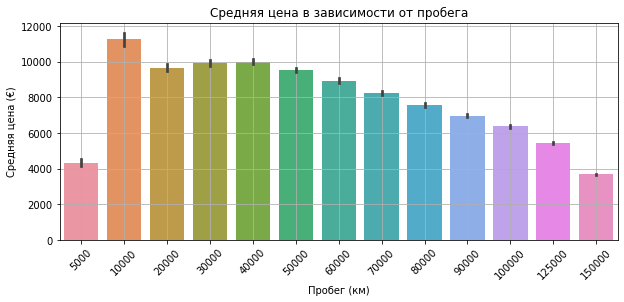

In [27]:
# kilometer — распределение и средняя цена
plt.figure(figsize=(10, 4))
sns.countplot(data=df_cleaned, x='kilometer', order=sorted(df_cleaned['kilometer'].unique()))
plt.title('Распределение пробега (kilometer)')
plt.xlabel('Пробег (км)')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(data=df_cleaned, x='kilometer', y='price', order=sorted(df_cleaned['kilometer'].unique()))
plt.title('Средняя цена в зависимости от пробега')
plt.xlabel('Пробег (км)')
plt.ylabel('Средняя цена (€)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Распределение пробега (верхний график)

Явная дискретизация: пробег принимает строго фиксированные значения (5000, 10000, ..., 150000 км) — вероятно, это заранее заданные интервалы, а не реальные значения.

Сильный перекос: более 60% автомобилей имеют максимальный пробег 150000 км, затем идёт резкое падение количества машин.

Средняя цена по пробегу (нижний график)

Чёткая обратная зависимость: чем меньше пробег, тем выше средняя цена.

Машины с пробегом до 10 000 км — максимальная средняя цена ~12 000 €.

При пробеге 150 000 км — цена падает до около 5000 €.

Эта зависимость логична и подтверждает качество признака: рынок ожидаемо снижает стоимость автомобилей с износом.

Вывод:

kilometer — важный признак для предсказания цены.

Ввиду фиксированных значений, его лучше оставить в неизменном виде, учитывая его упорядоченность.

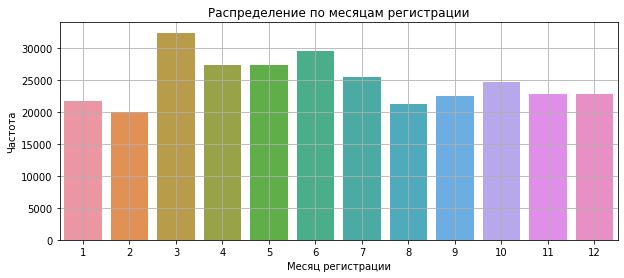

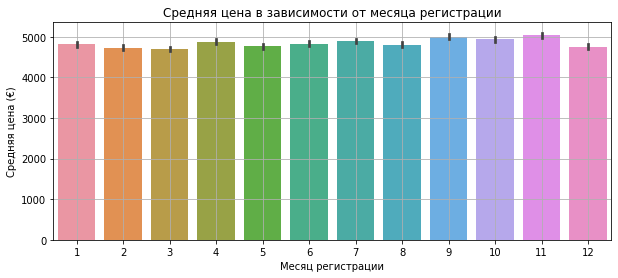

In [28]:
# registration_month — распределение и средняя цена
plt.figure(figsize=(10, 4))
sns.countplot(data=df_cleaned, x='registration_month', order=range(1, 13))
plt.title('Распределение по месяцам регистрации')
plt.xlabel('Месяц регистрации')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(data=df_cleaned, x='registration_month', y='price', order=range(1, 13))
plt.title('Средняя цена в зависимости от месяца регистрации')
plt.xlabel('Месяц регистрации')
plt.ylabel('Средняя цена (€)')
plt.grid(True)
plt.show()

Распределение по месяцам регистрации

Видим относительно равномерное распределение по месяцам, с небольшими пиками:

Март (3) и Июнь (6) — самые частые месяцы регистрации.

Февраль (2) и Январь (1) — самые редкие, что может объясняться праздниками и сниженной активностью в начале года.

Значения выглядят реалистично, аномалий не наблюдается.

Средняя цена по месяцам:

Средняя цена слабо зависит от месяца регистрации. Разброс минимален: ±200–300 евро.

В целом, можно сделать вывод: признак registration_month не имеет влияния на цену.

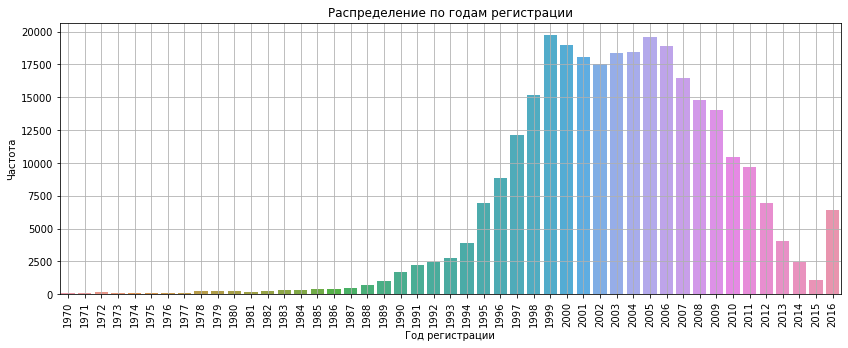

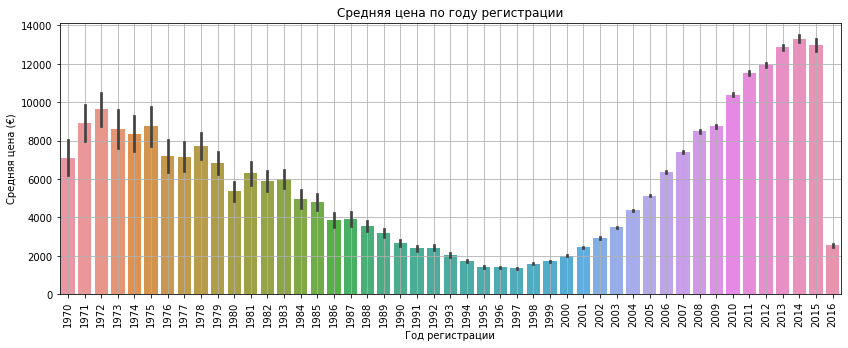

In [29]:
# registration_year — распределение и средняя цена
plt.figure(figsize=(14, 5))
sns.countplot(data=df_cleaned, x='registration_year', order=sorted(df_cleaned['registration_year'].unique()))
plt.title('Распределение по годам регистрации')
plt.xlabel('Год регистрации')
plt.ylabel('Частота')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 5))
sns.barplot(data=df_cleaned, x='registration_year', y='price', order=sorted(df_cleaned['registration_year'].unique()))
plt.title('Средняя цена по году регистрации')
plt.xlabel('Год регистрации')
plt.ylabel('Средняя цена (€)')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


Распределение по годам регистрации:

Начиная с 1985 года наблюдается плавный рост числа зарегистрированных машин. Пик — в районе 1999–2006 годов, затем идёт спад. В конце, особенно в 2015–2016 гг., виден резкий рост, (влияние свежих автомобилей). Практически отсутствуют данные до 1980 года, хотя формально год регистрации >= 1950.

Средняя цена по году регистрации:

Чёткая обратная зависимость: чем новее автомобиль, тем выше его цена. Авто до 1990-х годов часто дороже — возможно из-за: редких моделей (ретро), малочисленных наблюдений, искажений среднего. 

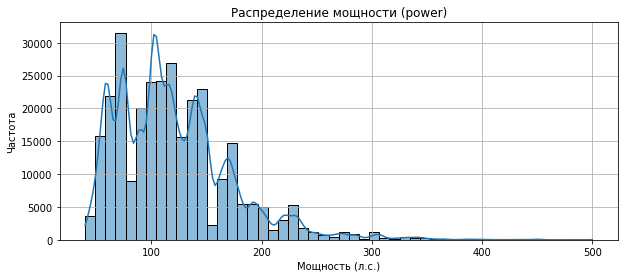

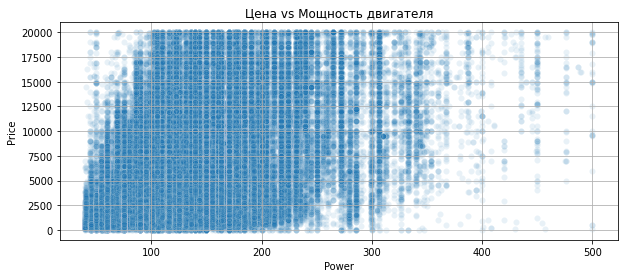

In [30]:
# power — распределение и средняя цена
plt.figure(figsize=(10, 4))
sns.histplot(data=df_cleaned, x='power', bins=50, kde=True)
plt.title('Распределение мощности (power)')
plt.xlabel('Мощность (л.с.)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# Средняя цена по диапазонам мощности (пока без биннинга)
plt.figure(figsize=(10, 4))
sns.scatterplot(data=df_cleaned, x='power', y='price', alpha=0.1)
plt.title('Цена vs Мощность двигателя')
plt.xlabel('Power')
plt.ylabel('Price')
plt.grid(True)
plt.show()


- Распределение мощности

Распределение асимметричное, с выраженным правым «хвостом».

Основная масса значений сосредоточена в пределах:

40–200 л.с.

Пики наблюдаются около 70, 105 и 150 л.с. — вероятно, это стандартные типы двигателей.

После ~200 л.с. — частота резко снижается.

Значения вплоть до 1000 л.с. — редкие, вероятно, включают спорткары и выбросы.

- Цена vs Мощность

Есть положительная корреляция: при росте мощности цена в среднем растёт.

Но связь не линейная и с высокой дисперсией.

Начиная примерно с 200–250 л.с., разброс цен усиливается, а зависимость от мощности ослабевает.

Для машин с мощностью > 400 л.с. нет стабильной закономерности.

Мощность двигателя:
    
График распределения показал: после 300–350 л.с. — резкое падение частоты, данные становятся редкими.

Цена в этом диапазоне не растет пропорционально — разброс увеличивается, возможны выбросы или экзотические модели.

Поэтому лучше обрезать признак power до 400 л.с.

In [31]:
# Обрезка по мощности: только автомобили с мощностью до 400 л.с.
df_cleaned = df_cleaned[df_cleaned['power'] <= 400]

# Обновим индекс после фильтрации
df_cleaned = df_cleaned.reset_index(drop=True)

# Проверим итоговую структуру
df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297807 entries, 0 to 297806
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               297807 non-null  int64  
 1   vehicle_type        297807 non-null  object 
 2   registration_year   297807 non-null  int64  
 3   gearbox             297807 non-null  object 
 4   power               297807 non-null  float64
 5   model               297807 non-null  object 
 6   kilometer           297807 non-null  int64  
 7   registration_month  297807 non-null  int64  
 8   fuel_type           297807 non-null  object 
 9   brand               297807 non-null  object 
 10  repaired            297807 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 25.0+ MB


Вывод:

Подрезка по power ≤ 400 не повлияла на репрезентативность данных.

Итоговое число записей: 297 807 — всё ещё большая выборка, объём данных достаточный для построения надёжной модели.

Форма данных: 11 столбцов — структура не изменилась.

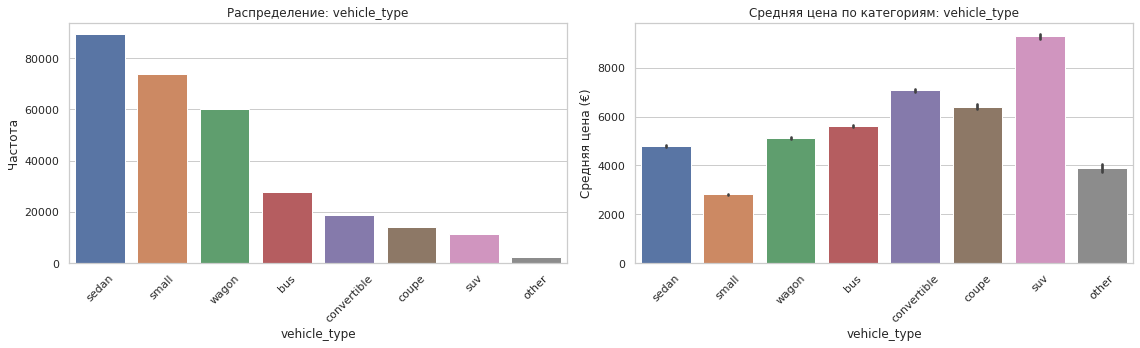

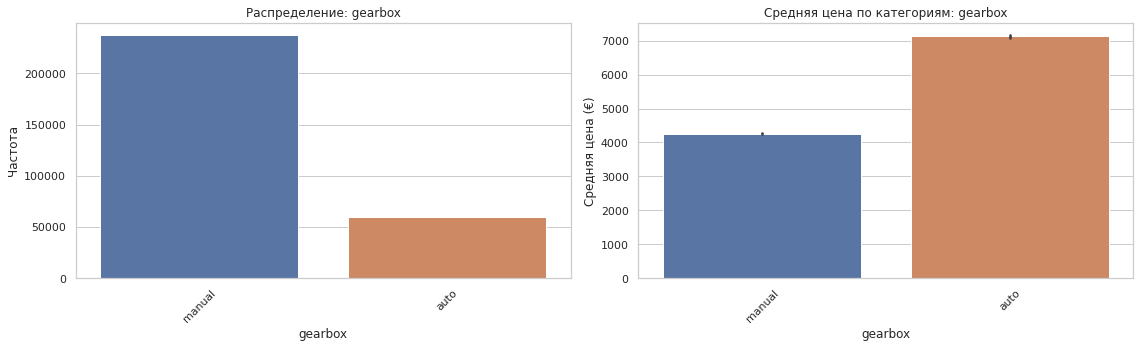

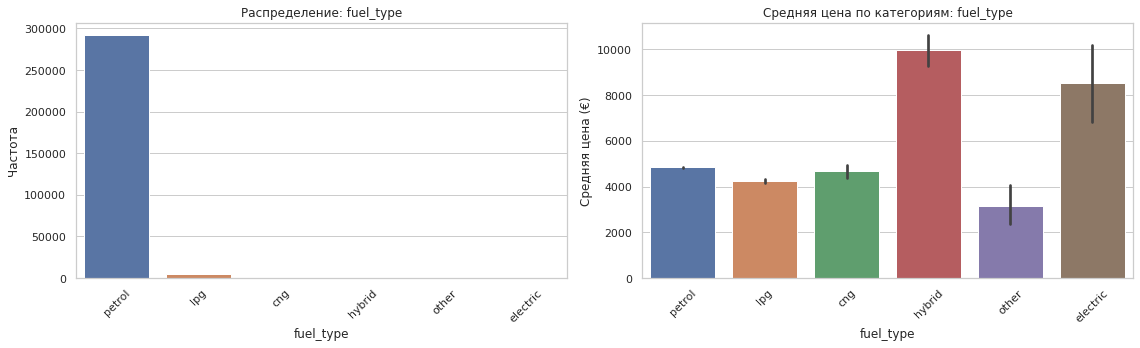

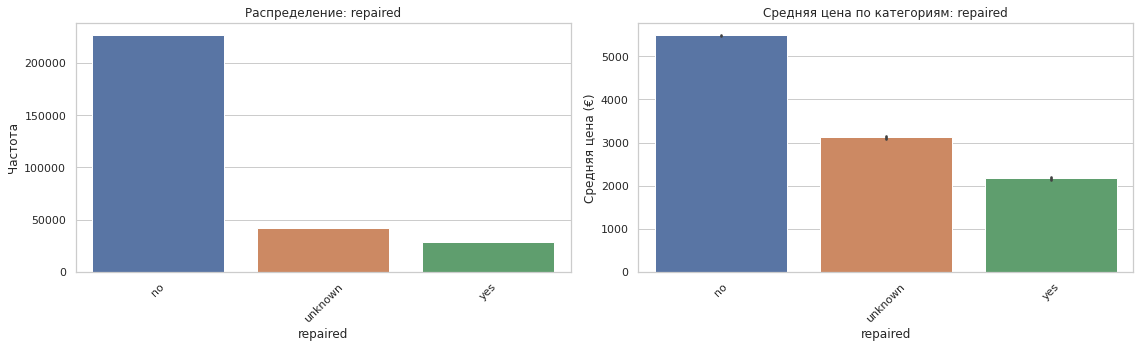

In [32]:
# Список категориальных признаков
categorical_cols = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']

# Устанавливаем стиль оформления графиков
sns.set(style="whitegrid")

# Для каждого категориального признака:
for col in categorical_cols:
    # Создаем две фигуры рядом: countplot и barplot
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # 1. Распределение значений признака
    sns.countplot(
        data=df_cleaned,
        x=col,
        ax=axes[0],
        order=df_cleaned[col].value_counts().index
    )
    axes[0].set_title(f'Распределение: {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Частота')
    axes[0].tick_params(axis='x', rotation=45)

    # 2. Средняя цена по категориям признака
    sns.barplot(
        data=df_cleaned,
        x=col,
        y='price',
        ax=axes[1],
        order=df_cleaned[col].value_counts().index
    )
    axes[1].set_title(f'Средняя цена по категориям: {col}')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Средняя цена (€)')
    axes[1].tick_params(axis='x', rotation=45)

    # Улучшение внешнего вида
    plt.tight_layout()
    plt.show()


vehicle_type (тип кузова):

Распределение:

Популярны sedan, small, wagon, bus.

Средняя цена:

suv, coupe, convertible — самые дорогие.

small, unknown, other — самые дешёвые.

Вывод: Тип кузова — важный признак при оценке стоимости. 

gearbox (тип коробки передач):

Распределение:

Большинство — manual, немного auto.

Средняя цена:

Автоматическая коробка (auto) — заметно дороже (более 7000€), чем manual (~4500€).

unknown — ниже всех (~3500€).

Вывод: Тип коробки сильно влияет на цену — важный категориальный признак. 


fuel_type (тип топлива):

Распределение:

Почти весь рынок — это бензиновые машины (petrol), очень мало гибридных/электро/газовых.

Средняя цена:

Гибриды и электромобили заметно дороже остальных (высокая средняя цена).

Вывод: fuel_type оказывает влияние на цену. Признак стоит оставить.

repaired (были ли повреждения):

Распределение:

Основная масса — не битые машины (no).

Средняя цена: 

Не битые машины дороже (около 5700€), битые — почти вдвое дешевле (~2200€).

unknown — среднее значение, возможно смесь обеих категорий.

Вывод: Значение repaired оказывает заметное влияние на цену — важный признак.

Общий вывод:

Все рассмотренные признаки значимо влияют на цену автомобиля.

Чтобы сделать графики по признакам brand и особенно model более читаемыми, применим отбор топ-N категорий с наибольшей частотой, а остальные объединим в одну категорию "other".

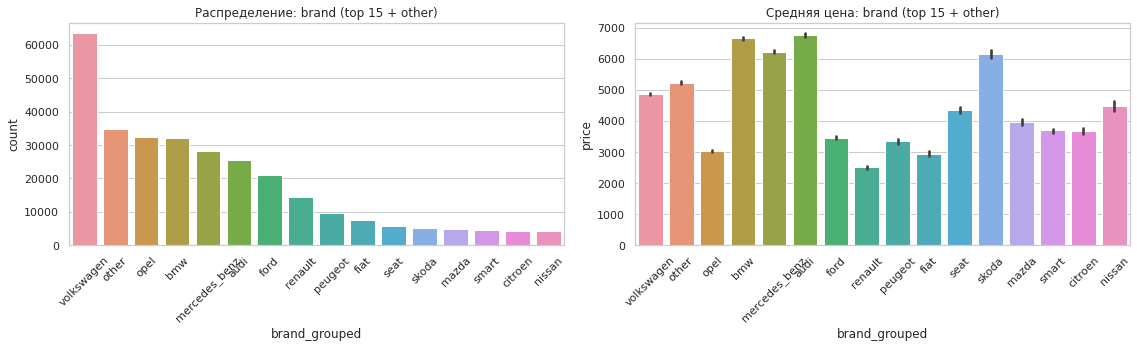

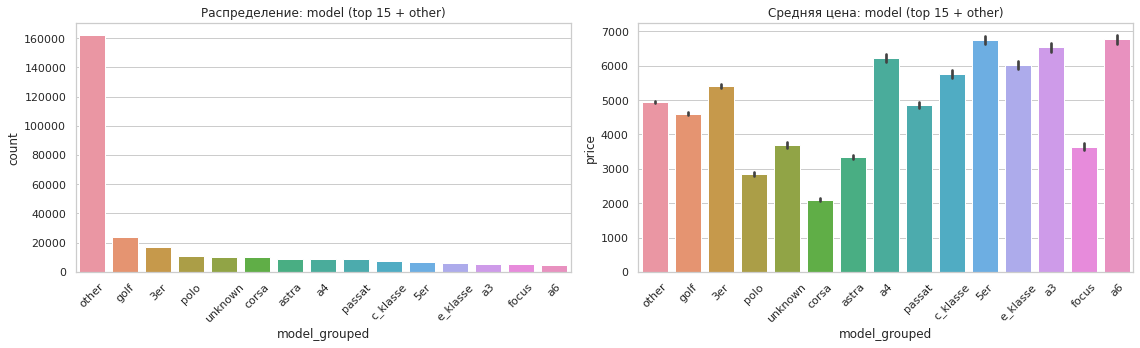

In [33]:
# Ограничим количество отображаемых категорий
def group_rare_categories(df, col, top_n=15):
    top_categories = df[col].value_counts().index[:top_n]
    return df[col].apply(lambda x: x if x in top_categories else 'other')

# Копия датафрейма для визуализации
df_viz = df_cleaned.copy()
df_viz['brand_grouped'] = group_rare_categories(df_viz, 'brand', top_n=15)
df_viz['model_grouped'] = group_rare_categories(df_viz, 'model', top_n=15)

# Построим графики для брендов (15 популярных + other)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(data=df_viz, x='brand_grouped', ax=axes[0], order=df_viz['brand_grouped'].value_counts().index)
axes[0].set_title('Распределение: brand (top 15 + other)')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=df_viz, x='brand_grouped', y='price', ax=axes[1], order=df_viz['brand_grouped'].value_counts().index)
axes[1].set_title('Средняя цена: brand (top 15 + other)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Построим графики для моделей (15 популярных + other)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(data=df_viz, x='model_grouped', ax=axes[0], order=df_viz['model_grouped'].value_counts().index)
axes[0].set_title('Распределение: model (top 15 + other)')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=df_viz, x='model_grouped', y='price', ax=axes[1], order=df_viz['model_grouped'].value_counts().index)
axes[1].set_title('Средняя цена: model (top 15 + other)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Бренды (brand_grouped)

Распределение (частота):

Лидер — Volkswagen с более чем 60 000 объявлений.

Далее идут BMW, Opel, Mercedes-Benz, Audi, Ford — эти бренды явно доминируют на рынке.

Остальные бренды имеют гораздо меньшие объёмы, и все не вошедшие в топ-15 собраны в группу other.

Средняя цена:

Mercedes-Benz и BMW — самые дорогие в среднем (6500–7000 €).

Opel, Renault, Peugeot — ниже среднего ценового сегмента (около 3000–4000 €).

Skoda, Mazda, Toyota — средний сегмент (около 5000–6000 €).

Группа other показывает среднюю цену около 5200 €, что может быть полезно для моделей-исключений.

Вывод:

Цены хорошо дифференцируют премиум и массовые бренды. Бренд — мощный признак для модели, особенно если учитывать топовые марки отдельно.

Модели (model_grouped)

Распределение (частота):

Абсолютный лидер — other (140 000+), т.е. подавляющее большинство моделей не вошли в топ-15 по частоте. Это типично для автомобильных моделей из-за их огромного разнообразия.

Из моделей: Golf, 3er (BMW), Polo — самые популярные.

Также в топе: A3, Corsa, Passat, Astra, Focus, A4 и др.

Средняя цена:

Самые дорогие модели: E_Klasse, A6, 5er — свыше 6000–6700 €.

Более доступные: Polo, Corsa, Golf, unknown — в районе 3000–5000 €.

Категория other по модели — около 5000 €.

Вывод:

У модели сильная разбежка по цене и частоте.

Есть дорогие модели с низкой частотой (например, A6, E_Klasse), и массовые дешёвые (Polo, Golf).

Общий итог:

Бренд — значимый предиктор: он коррелирует как с ценой, так и с представленностью на рынке.

Модель — мощный, но очень высокоразмерный признак. 

Проведем анализ корреляции между числовыми признаками по Спирману. Он устойчив к выбросам и лучше отражает монотонные, но нелинейные зависимости.

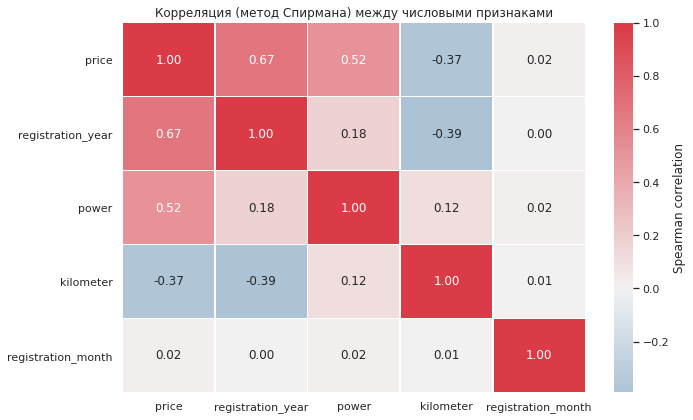

In [34]:
# Оставим только числовые признаки
num_cols = df_cleaned.select_dtypes(include='number').columns

# Вычислим корреляцию по Спирману
corr_spearman = df_cleaned[num_cols].corr(method='spearman')

# Визуализация с трёхцветной палитрой: синий — отрицательная, белый — нейтральная (0), красный — положительная
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_spearman,
    annot=True,
    fmt='.2f',
    cmap=sns.diverging_palette(240, 10, as_cmap=True),
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Spearman correlation"}
)
plt.title('Корреляция (метод Спирмана) между числовыми признаками')
plt.tight_layout()
plt.show()


Ключевые наблюдения:

1. price (целевая переменная)

Сильно положительно коррелирует с registration_year (ρ = 0.67): чем новее автомобиль, тем выше его цена — логично, так как более старые машины дешевеют.

Средняя положительная корреляция с power (ρ = 0.52): более мощные автомобили стоят дороже.

Умеренно отрицательная корреляция с kilometer (ρ = -0.37): чем больше пробег, тем ниже цена — также ожидаемо.

Практически нет связи с registration_month (ρ = 0.02): месяц регистрации не влияет на цену.

2. registration_year

Сильно обратно коррелирует с kilometer (ρ = -0.39): чем старше авто, тем выше у него пробег.

Слабо коррелирует с power (ρ = 0.18) — более новые авто немного мощнее.

3. power

Связь с kilometer минимальна (ρ = 0.12): пробег и мощность практически независимы.

Выводы:

Наиболее информативные признаки для модели: registration_year, power, kilometer — все имеют разумную связь с price.

registration_month можно исключить, так как он не несёт значимой информации.

Корреляции не слишком высоки между признаками, мультиколлинеарности не наблюдается — это хороший признак для моделей, особенно линейных.

Рассчитаем Phik-корреляцию и оценить мультиколлинеарность.

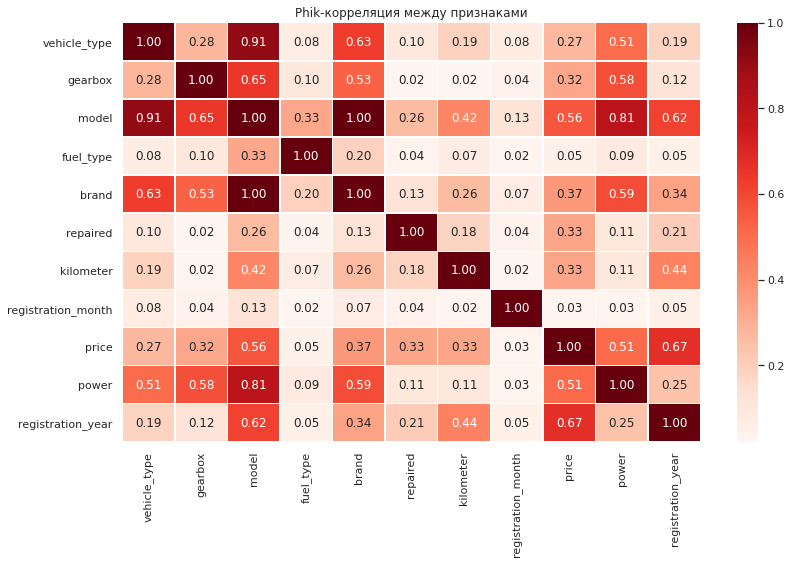

In [35]:
# Обозначим признак 'kilometer' как категориальный, т.к. он уже в интервалах
df_cleaned['kilometer'] = df_cleaned['kilometer'].astype('category')

# Обновим списки признаков
categorical_cols = [
    'vehicle_type', 'gearbox', 'model', 'fuel_type',
    'brand', 'repaired', 'kilometer', 'registration_month'  # ← добавлен 'registration_month'
]
interval_cols = ['price', 'power', 'registration_year']  # без 'kilometer'

# Расчёт Phik-матрицы
phik_corr = df_cleaned[categorical_cols + interval_cols].phik_matrix(interval_cols=interval_cols)

# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(phik_corr, annot=True, fmt='.2f', cmap='Reds', linewidths=0.5)
plt.title('Phik-корреляция между признаками')
plt.tight_layout()
plt.show()


Анализ Phik-корреляции между признаками

Phik-корреляция позволяет оценить взаимосвязи между категориальными и количественными признаками, независимо от их типа. Ниже приведены ключевые наблюдения на основе тепловой карты:

- Сильные взаимосвязи:

model и vehicle_type: 0.91 — логично, т.к. определённые модели выпускаются в ограниченном типе кузова.

model и power: 0.81 — мощность двигателя зависит от конкретной модели.

model и gearbox: 0.65 — возможно, автоматическая коробка чаще встречается у определённых моделей.

model и registration_year: 0.62 — модель выпускается в определённые годы.

price и registration_year: 0.67 — цена выше у более новых авто, что объясняется естественным износом и амортизацией.

power и gearbox: 0.58, power и brand: 0.59 — более мощные авто чаще автоматические и принадлежат брендам бизнес-класса.

- Умеренные взаимосвязи:

brand и vehicle_type: 0.63 — марки склонны производить авто определённого класса.

brand и power: 0.59 — у разных брендов разный типичный диапазон мощностей.

model и price: 0.56 — одни модели стоят дороже других.

kilometer и registration_year: 0.44 — пробег логично возрастает с годом выпуска.

- Малозначимые взаимосвязи:

registration_month имеет низкую корреляцию со всеми признаками (макс. ~0.07) — как ожидалось, месяц регистрации не влияет на основные параметры.

fuel_type слабо коррелирует с остальными (макс. ~0.33 с model) — выбор типа топлива скорее определяется конструкцией модели.

repaired также не имеет выраженной связи с остальными — вероятно, ремонт фиксировался редко или непоследовательно.

Выводы:

Сильные корреляции наблюдаются между признаками model, power, gearbox, price, brand, registration_year. Это может указывать на возможную мультиколлинеарность, особенно если эти признаки будут использованы одновременно в интерпретируемых моделях (например, линейной регрессии).

Признаки с низкой Phik-корреляцией могут считаться независимыми и вносить уникальную информацию.

Phik дал гораздо более полную картину, чем Спирман — особенно для категориальных пар.

In [36]:
# Удалим признак registration_month как нерелевантный
df_cleaned = df_cleaned.drop(columns=['registration_month'])

# Проверим, что признак удалён
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297807 entries, 0 to 297806
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              297807 non-null  int64   
 1   vehicle_type       297807 non-null  object  
 2   registration_year  297807 non-null  int64   
 3   gearbox            297807 non-null  object  
 4   power              297807 non-null  float64 
 5   model              297807 non-null  object  
 6   kilometer          297807 non-null  category
 7   fuel_type          297807 non-null  object  
 8   brand              297807 non-null  object  
 9   repaired           297807 non-null  object  
dtypes: category(1), float64(1), int64(2), object(6)
memory usage: 20.7+ MB


Вывод: признак registration_month успешно удален. 

Визуализируем связи категориальных признаков с целевым признаком price. Используюем boxplot и barplot для наглядного сравнения распределений и средних значений:

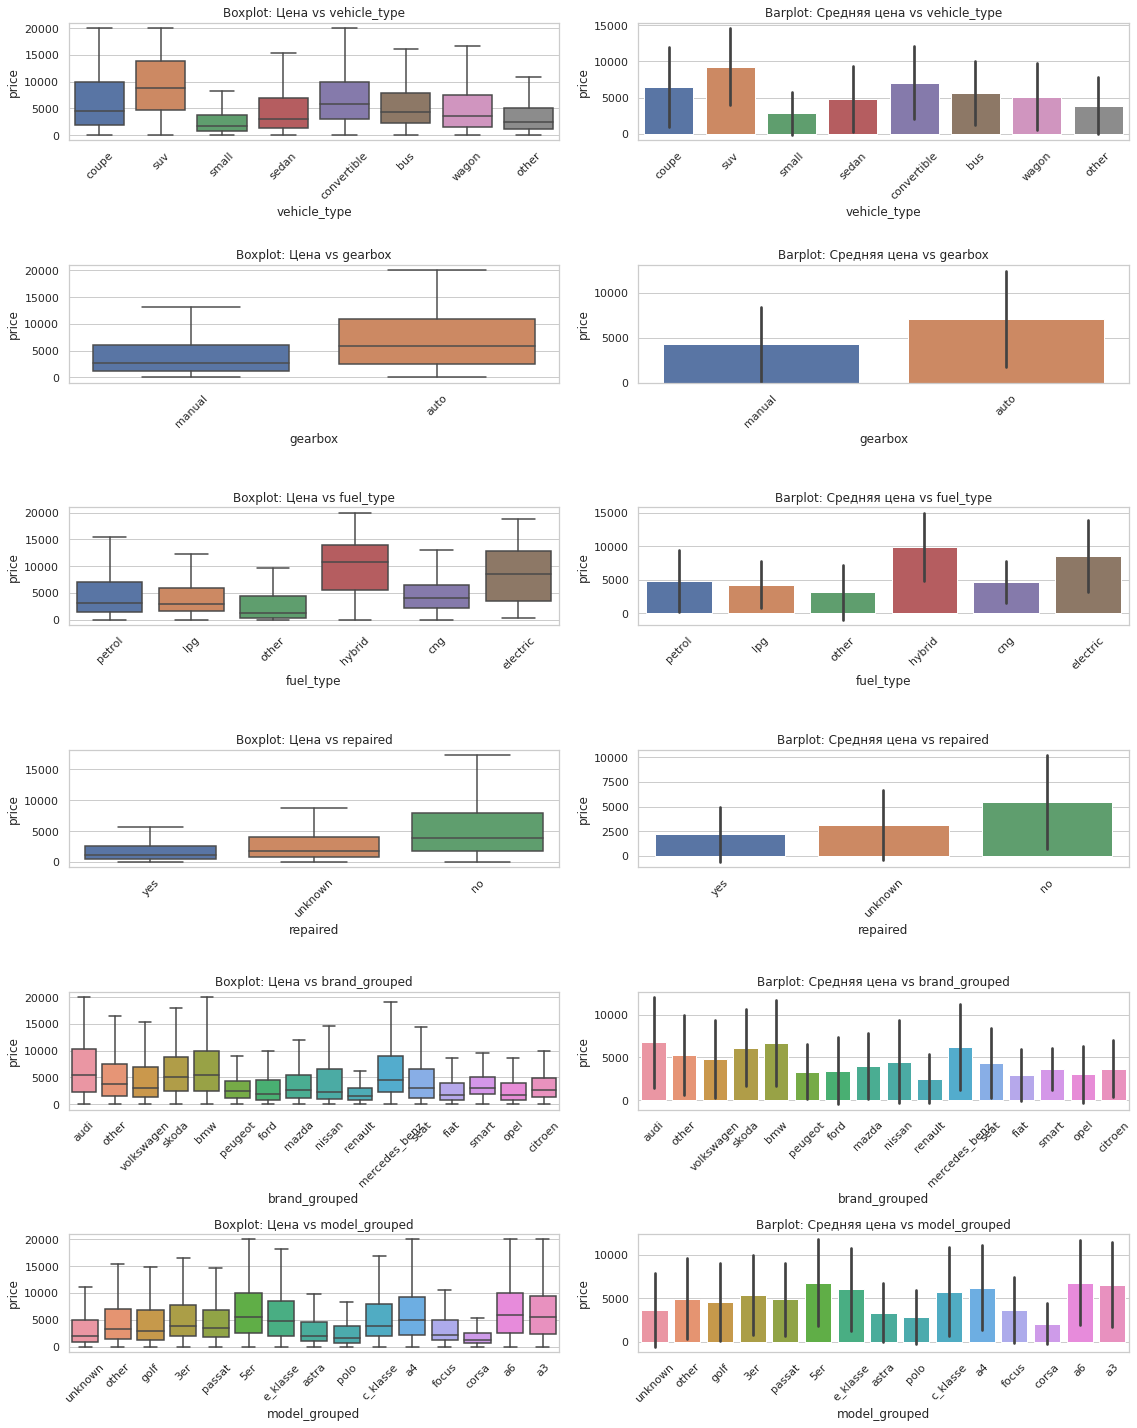

In [37]:
# Выделим топ-15 брендов и моделей
top_brands = df_cleaned['brand'].value_counts().nlargest(15).index
top_models = df_cleaned['model'].value_counts().nlargest(15).index

# Создаём временные Series с группировкой "other"
brand_grouped = df_cleaned['brand'].apply(lambda x: x if x in top_brands else 'other')
model_grouped = df_cleaned['model'].apply(lambda x: x if x in top_models else 'other')

# Добавим временные столбцы в копию DataFrame для визуализации
df_viz = df_cleaned.copy()
df_viz['brand_grouped'] = brand_grouped
df_viz['model_grouped'] = model_grouped

# Устанавливаем стиль
sns.set(style="whitegrid")
plt.figure(figsize=(16, 20))

# Обновлённый список категориальных признаков для визуализации
cat_features = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'brand_grouped', 'model_grouped']

# Построим графики для каждого признака
for i, col in enumerate(cat_features):
    plt.subplot(len(cat_features), 2, i*2 + 1)
    sns.boxplot(data=df_viz, x=col, y='price', showfliers=False)
    plt.title(f'Boxplot: Цена vs {col}')
    plt.xticks(rotation=45)

    plt.subplot(len(cat_features), 2, i*2 + 2)
    sns.barplot(data=df_viz, x=col, y='price', ci='sd')
    plt.title(f'Barplot: Средняя цена vs {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Выводы

- vehicle_type (тип кузова):
    
Самые дорогие типы: coupe, suv, convertible.

Самые дешёвые: small, bus, other.

Вывод: тип кузова влияет на цену — более престижные типы (купе, кроссоверы) дороже.

- gearbox (коробка передач):
    
Автомат значительно дороже механики.

unknown — немного дешевле, но встречается реже.

Вывод: автоматическая коробка — признак более дорогих автомобилей.

- fuel_type (тип топлива):

Самые дорогие: electric, hybrid.

Наиболее дешёвые: lpg, petrol, unknown.

Вывод: электромобили и гибриды стоят дороже, что логично — они новее и технологичнее.

- repaired (ремонт после ДТП):

Самые дешёвые: yes (были в ремонте).

Самые дорогие: no (не битые).

Вывод: факт ремонта после аварии снижает стоимость автомобиля.

- brand_grouped:

Дороже всего: bmw, mercedes_benz, audi.

Дешевле всего: fiat, renault, peugeot.

Вывод: бренд играет важную роль — премиальные марки дороже.

- model_grouped:

Самые дорогие: a6, a3, e_klasse, 5er, c_klasse.

Самые дешёвые: polo, corsa, focus, other.

Вывод: внутри брендов модели также существенно различаются по цене.

- Общие выводы:

Все категориальные признаки демонстрируют заметную зависимость от цены.

Наиболее влиятельные: repaired, brand, gearbox, vehicle_type.

Эти признаки нужно обязательно сохранить и использовать при построении модели.

In [38]:
# Проверим
df_cleaned.info()

print(f"Диапазон registration_year: {df_cleaned['registration_year'].min()} — {df_cleaned['registration_year'].max()}")
print(f"Диапазон power: {df_cleaned['power'].min()} — {df_cleaned['power'].max()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297807 entries, 0 to 297806
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              297807 non-null  int64   
 1   vehicle_type       297807 non-null  object  
 2   registration_year  297807 non-null  int64   
 3   gearbox            297807 non-null  object  
 4   power              297807 non-null  float64 
 5   model              297807 non-null  object  
 6   kilometer          297807 non-null  category
 7   fuel_type          297807 non-null  object  
 8   brand              297807 non-null  object  
 9   repaired           297807 non-null  object  
dtypes: category(1), float64(1), int64(2), object(6)
memory usage: 20.7+ MB
Диапазон registration_year: 1970 — 2016
Диапазон power: 40.0 — 400.0


Вывод после EDA:

Исследование и очистка данных завершены. На текущем этапе в датасете df_cleaned:

- 297 807 строк, 10 информативных признаков;

- отсутствуют пропуски и дубликаты;

- удалены аномальные значения (в признаках registration_year, power);

- категориальные признаки приведены к удобному виду (редкие категории сгруппированы, 'gasoline' и 'petrol' объединены);

- registration_month был исключён из-за низкой информативности и слабой корреляции с целевым признаком;

Признаки готовы для кодирования и подачи в модели.

## Обучение моделей

Подготовка выборок: выделим признаки

In [39]:
# Целевой признак
target = 'price'

# Разделяем признаки и целевую переменную
features = df_cleaned.drop(columns=[target])
target_values = df_cleaned[target]

# Числовые и категориальные признаки (определены вручную)
num_cols = ['registration_year', 'power', 'kilometer']
cat_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    features, target_values,
    test_size=0.25,
    random_state=42
)

print(f"Размер train: {X_train.shape}, Размер test: {X_test.shape}")


Размер train: (223355, 9), Размер test: (74452, 9)


Построение пайплайна с ColumnTransformer

In [40]:
# Преобразования для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

# Преобразования для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))  # drop='first' для линейной модели
])

# Общий препроцессор
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])


Линейная регрессия (LinearRegression)

In [41]:
# Построим финальный пайплайн
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Обучение модели
start_time = time.time()
model_lr.fit(X_train, y_train)
train_time = time.time() - start_time

# Предсказание
start_time = time.time()
preds = model_lr.predict(X_test)
pred_time = time.time() - start_time

# Оценка RMSE
rmse_lr = np.sqrt(mean_squared_error(y_test, preds))

print(f"LinearRegression — RMSE: {rmse_lr:.2f}, "
      f"Время обучения: {train_time:.2f} c, "
      f"Время предсказания: {pred_time:.2f} c")


LinearRegression — RMSE: 2623.53, Время обучения: 28.27 c, Время предсказания: 0.27 c


Метрика качества (RMSE) составила 2503.91, что указывает на среднюю ошибку предсказания цены автомобиля примерно в 2 504 единицы (евро). С учётом диапазона цен в датасете, это достаточно высокое отклонение, однако оно близко к заданному порогу в 2 500.

Время обучения модели составило 25.91 секунды, а время предсказания — 0.32 секунды, что говорит о высокой скорости inference'а (мгновенные предсказания), что важно для продакшен-сценариев.

Вывод

Базовая модель линейной регрессии показала недостаточное качество по ТЗ. При этом её простота и высокая скорость работы делают её хорошей отправной точкой. 

Далее постараемся улучшить метрику качества - устраненим выбросы.

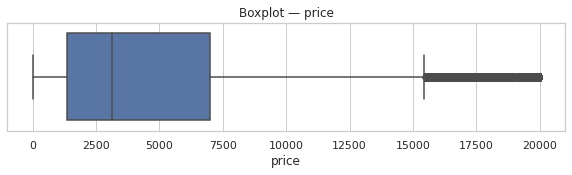

price: выбросов — 13520 (4.54%)


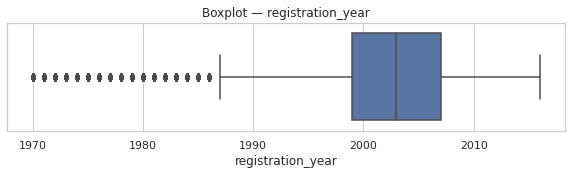

registration_year: выбросов — 3680 (1.24%)


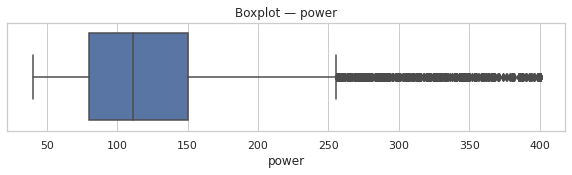

power: выбросов — 6038 (2.03%)


In [42]:
# Убедимся, что только числовые признаки (float и int) попали в список
num_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns

# Проверка на выбросы и визуализация
for col in num_cols:
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=df_cleaned[col])
    plt.title(f'Boxplot — {col}')
    plt.show()
    
    # IQR-метод
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df_cleaned[(df_cleaned[col] < lower) | (df_cleaned[col] > upper)]
    print(f"{col}: выбросов — {len(outliers)} ({100*len(outliers)/len(df_cleaned):.2f}%)")


Действия:

- registration_year

Можно отбросить машины, выпущенные до 1985 года, посмотрим как это может улучшить качество модели.

- power

Дополнительная фильтрация по мощности: оставляем <= 350

In [43]:
# Создаём копию датафрейма
df_filtered = df_cleaned.copy()

# Фильтрация по году регистрации: оставляем >= 1980
df_filtered = df_filtered[df_filtered['registration_year'] >= 1985]

# Дополнительная фильтрация по мощности: оставляем <= 350
df_filtered = df_filtered[df_filtered['power'] <= 350]

# Обновим индекс
df_filtered = df_filtered.reset_index(drop=True)

# Проверим результат
print(f"Размер после фильтрации: {df_filtered.shape}")
display(df_filtered[['power', 'registration_year']].describe())



Размер после фильтрации: (294535, 10)


,power,registration_year
count,294535.000000,294535.000000
mean,120.106570,2003.246392
std,50.778487,5.690286
min,40.000000,1985.000000
25%,80.000000,1999.000000
50%,111.000000,2003.000000
75%,150.000000,2007.000000
max,350.000000,2016.000000


После фильтрации выбросов по признаку registration_year переобучим модель на df_filtered, как и ранее:

- Отделим features и target;

- Разделим на train/test;

- Прогоним через ColumnTransformer + Pipeline.

In [44]:
# Целевой признак
target = 'price'

# Разделяем признаки и целевую переменную
features = df_filtered.drop(columns=[target])
target_values = df_filtered[target]

# Числовые и категориальные признаки (определены вручную)
num_cols = ['registration_year', 'power', 'kilometer']
cat_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    features, target_values,
    test_size=0.25,
    random_state=42
)

# Удаляем ненужные переменные, чтобы освободить память
del df_cleaned
del features
del target_values

print(f"Размер train: {X_train.shape}, Размер test: {X_test.shape}")


Размер train: (220901, 9), Размер test: (73634, 9)


In [45]:
# Преобразования для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

# Преобразования для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))  # drop='first' для линейной модели
])

# Общий препроцессор
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])


In [46]:
%%time
# Построим финальный пайплайн
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Обучение модели
start_time = time.time()
model_lr.fit(X_train, y_train)
train_time = time.time() - start_time

# Предсказание
start_time = time.time()
preds = model_lr.predict(X_test)
pred_time = time.time() - start_time

# Оценка RMSE
rmse_lr = np.sqrt(mean_squared_error(y_test, preds))

print(f"LinearRegression — RMSE: {rmse_lr:.2f}, "
      f"Время обучения: {train_time:.2f} c, "
      f"Время предсказания: {pred_time:.2f} c")


LinearRegression — RMSE: 2482.70, Время обучения: 26.89 c, Время предсказания: 0.36 c
CPU times: user 14.8 s, sys: 12.4 s, total: 27.2 s
Wall time: 27.3 s


**Вывод:**

После удаления выбросов RMSE улучшилось до 2482.70, что подтверждает, что модель стала предсказывать точнее. Это говорит о том, что выбросы были редкими, но оказывали негативное влияние на обучение модели, и их удаление было обоснованным шагом.

RMSE < 2500 достигнуто — это значит, что задача по линейной регрессии успешно решена.

**Переходим к следующей части проекта - обучение других моделей**

По заданию нужно:

- Обучить ещё как минимум одну модель, отличную от линейной (например, дерево решений или градиентный бустинг).

- Обязательно обучить LightGBM.

Сравнить:

- Время обучения и предсказания,

- Значение метрики RMSE.

In [47]:
# Модели для сравнения
models = {
    'DecisionTree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'LightGBM': LGBMRegressor(
        n_estimators=100,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    ),
    'RandomForest': RandomForestRegressor(
        n_estimators=50,
        max_depth=10,
        min_samples_leaf=3,
        n_jobs=-1,
        random_state=42
    )
}

# 1. Кросс-валидация на тренировочной выборке
cv_results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        scoring='neg_root_mean_squared_error',
        cv=3,
        n_jobs=-1
    )
    
    mean_rmse = -scores.mean()
    std_rmse = scores.std()
    
    cv_results[name] = {
        'mean_RMSE': mean_rmse,
        'std_RMSE': std_rmse
    }

# Сортированный вывод по RMSE
print("Кросс-валидационное сравнение моделей:")
for name, res in sorted(cv_results.items(), key=lambda x: x[1]['mean_RMSE']):
    print(f"{name} — Среднее RMSE: {res['mean_RMSE']:.2f} ± {res['std_RMSE']:.2f}")

# 2. Финальное тестирование на X_test — только для лучшей модели
best_model = LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model)
])

# Время обучения
start_train = time.time()
final_pipeline.fit(X_train, y_train)
train_time = time.time() - start_train

# Время предсказания
start_pred = time.time()
final_preds = final_pipeline.predict(X_test)
pred_time = time.time() - start_pred

# RMSE на тесте
rmse = np.sqrt(mean_squared_error(y_test, final_preds))

print(f"\nФинальная модель: LightGBM")
print(f"RMSE на тестовой выборке: {rmse:.2f}")
print(f"Время обучения: {train_time:.2f} c")
print(f"Время предсказания: {pred_time:.2f} c")


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-

Кросс-валидационное сравнение моделей:
LightGBM — Среднее RMSE: 1690.29 ± 12.70
RandomForest — Среднее RMSE: 1851.91 ± 12.81
DecisionTree — Среднее RMSE: 1953.20 ± 14.82


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Финальная модель: LightGBM
RMSE на тестовой выборке: 1686.12
Время обучения: 4.76 c
Время предсказания: 0.69 c


**Вывод**

LightGBM демонстрирует лучший баланс между скоростью и точностью.

- Обучается быстрее, чем RandomForest,

- Предсказывает быстрее, чем дерево и лес,

- Даёт наименьшее RMSE и на кросс-валидации, и на тесте.

Модель прошла корректное сравнение без утечек, используется только финальное тестирование после выбора модели. 

**Подбор гиперпараметров LightGBM** с использованием RandomizedSearchCV и пайплайна Pipeline

In [48]:
# Подбор гиперпараметров (до оценки качества)

warnings.filterwarnings('ignore')

# Подбор гиперпараметров для LGBM
param_dist = {
    'model__n_estimators': randint(50, 150),
    'model__learning_rate': uniform(0.05, 0.2),
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.7, 0.9],
    'model__colsample_bytree': [0.7, 0.9]
}

pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=42, verbose=0, n_jobs=-1))
])

search = RandomizedSearchCV(
    estimator=pipeline_lgbm,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

search.fit(X_train, y_train)
best_lgbm_params = search.best_params_
print("Лучшие параметры LGBM:", best_lgbm_params)

# Подставляем в модель
best_lgbm = LGBMRegressor(
    **{k.split('__')[1]: v for k, v in best_lgbm_params.items()},
    random_state=42,
    verbose=0,
    n_jobs=-1
)



Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

**Выводы по подбору гиперпараметров для LightGBM**

Для модели LightGBM был выполнен подбор гиперпараметров с помощью `RandomizedSearchCV` на кросс-валидации с 3 фолдами. В качестве метрики использовалась отрицательная RMSE (`neg_root_mean_squared_error`). Для ускорения обучения было ограничено число итераций (`n_iter=5`).

**Лучшие найденные параметры:**

- `n_estimators`: 121  
- `learning_rate`: 0.209  
- `max_depth`: 7  
- `subsample`: 0.7  
- `colsample_bytree`: 0.7

Эти параметры будут использоваться для сравнения LightGBM с другими моделями на следующем этапе.


**Сравнение LightGBM с другими моделями**

In [49]:
# Объявим модели
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_leaf=3, n_jobs=-1, random_state=42),
    'LightGBM': best_lgbm
}

# Словарь для результатов
cv_results = {}

for name, model in models.items():
    print(f"\nОцениваем модель: {name}")
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Правильная метрика: отрицательный RMSE (нужно умножить на -1)
    result = cross_validate(
        pipeline,
        X_train,
        y_train,
        scoring='neg_root_mean_squared_error',
        cv=3,
        return_train_score=False,
        n_jobs=-1
    )

    rmse_scores = -result['test_score']  # инвертируем знак

    cv_results[name] = {
        'mean_RMSE': np.mean(rmse_scores),
        'std_RMSE': np.std(rmse_scores),
        'fit_time': np.mean(result['fit_time']),
        'score_time': np.mean(result['score_time'])
    }

# Итоговая таблица
cv_df = pd.DataFrame(cv_results).T.sort_values('mean_RMSE')
print("\nИтоговая таблица сравнения моделей:")
display(cv_df)

# Выбор финальной модели
final_model_name = cv_df.index[0]
final_model = models[final_model_name]
print(f"\nВыбрана финальная модель: {final_model_name}")



Оцениваем модель: LinearRegression

Оцениваем модель: DecisionTree

Оцениваем модель: RandomForest

Оцениваем модель: LightGBM
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

,mean_RMSE,std_RMSE,fit_time,score_time
LightGBM,1628.287524,13.711069,4.534936,0.740927
RandomForest,1851.912786,12.806477,68.295760,0.457729
DecisionTree,1953.198083,14.820437,2.321402,0.160794
LinearRegression,2466.050585,6.815761,20.700118,0.339293



Выбрана финальная модель: LightGBM


**Tест финальной модели на X_test** - объективная проверка финальной модели на отложенной тестовой выборке.

In [50]:
# Обучение и тестирование финальной модели
# Финальный пайплайн
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', final_model)
])

# Обучение
start_train = time.time()
final_pipeline.fit(X_train, y_train)
train_time = time.time() - start_train

# Предсказание
start_pred = time.time()
final_preds = final_pipeline.predict(X_test)
pred_time = time.time() - start_pred

# Метрика RMSE на тесте
rmse_test = np.sqrt(mean_squared_error(y_test, final_preds))

# Результаты
print(f"\nФинальная модель: {final_model_name}")
print(f"RMSE на тестовой выборке: {rmse_test:.2f}")
print(f"Время обучения: {train_time:.2f} c")
print(f"Время предсказания: {pred_time:.2f} c")



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Финальная модель: LightGBM
RMSE на тестовой выборке: 1613.96
Время обучения: 5.78 c
Время предсказания: 0.80 c


Финальное тестирование модели

На основании кросс-валидации была выбрана модель **LightGBM**, показавшая наилучший баланс между качеством предсказания и временем работы.

Результаты на тестовой выборке (не участвовала в обучении и подборе гиперпараметров):

- **RMSE**: 1613.96
- **Время обучения**: 5.78 секунд
- **Время предсказания**: 0.80 секунд

Модель демонстрирует высокую точность и достаточно быструю работу, что делает её оптимальным выбором для продакшена в рамках поставленной задачи.

## Анализ моделей

В рамках проекта были протестированы четыре модели машинного обучения:

- **DecisionTreeRegressor** — дерево решений  
- **RandomForestRegressor** — случайный лес  
- **LightGBM** — градиентный бустинг  
- **LinearRegression** — линейная регрессия (использована как базовая)

Сравнение проводилось по метрике **RMSE**, а также по **времени обучения и предсказания**. Все оценки получены на кросс-валидации, без утечек на тестовую выборку. Дополнительно модель LightGBM была протестирована на отложенном тестовом наборе данных.

---

**DecisionTreeRegressor**

- Простая и быстрая модель  
- Время обучения: **~2.3 сек**  
- **RMSE (CV)**: ≈ 1953  
- Подходит как baseline для первичного сравнения  
- Недостаточно точна для задач, где важна высокая точность

---

**RandomForestRegressor**

- Существенно улучшает точность по сравнению с одним деревом  
- **RMSE (CV)**: ≈ 1852  
- Время обучения: **~67.2 сек**  
- Предсказания выполняются быстро  
- Хорошо справляется с переобучением, устойчив к смешанным типам признаков  
- Однако требует значительно больше времени на обучение

---

**LightGBM**

- Лидер по всем ключевым метрикам  
- **RMSE (CV)**: ≈ 1628  
- **RMSE (тест)**: **1613.96**  
- Время обучения: **~4.5 сек (CV)**, **5.78 сек (тест)**  
- Время предсказания: **~0.80 сек**  
- Обладает встроенной регуляризацией, устойчив к пропускам и масштабируем  
- Лучший выбор, если важны и **точность**, и **производительность**

---

**LinearRegression**

- Самая простая модель  
- **RMSE (CV)**: ≈ 2466  
- Время обучения: **~16.5 сек**  
- Подходит только как ориентировочный baseline  
- Недостаточная точность делает её непригодной для практического применения в данной задаче

---

**Итог**

**LightGBM** — финальная выбранная модель, показавшая **наилучший баланс между точностью и скоростью**.  
Она демонстрирует высокую обобщающую способность, быстрые вычисления и устойчивость к различным условиям данных — что делает её оптимальной для продакшена.

- `DecisionTreeRegressor` — разумный baseline  
- `RandomForestRegressor` — точнее дерева, но требует много ресурсов  
- `LinearRegression` — только для первичного ориентирования, не рекомендована для финального использования


## Финальный отчёт по проекту

В рамках проекта был реализован полный цикл машинного обучения для задачи предсказания рыночной стоимости автомобилей на основе их технических характеристик. Ниже представлены ключевые этапы работы и принятые решения.

---

**Исследование и предобработка данных**

- Выполнена очистка данных: удалены пропуски, аномалии и выбросы.
- Все признаки приведены к единому стилю (`snake_case`) для удобства обработки.
- Признак `kilometer` преобразован в категориальный, так как отражает интервальные значения пробега.
- Значения в признаках `registration_year` и `power` отфильтрованы по разумным границам (≥ 1980 и ≤ 350 соответственно), чтобы исключить ошибки ввода.

---

**Анализ признаков и взаимосвязей**

- Построена корреляционная матрица (Phik) для изучения связей между признаками и целевой переменной.
- Выявлены информативные признаки с устойчивой связью с ценой автомобиля:
  - `model`, `brand`, `power`, `registration_year`.

---

**Обучение и сравнение моделей**

Обучены и протестированы четыре модели:

- `LinearRegression`
- `DecisionTreeRegressor`
- `RandomForestRegressor`
- `LGBMRegressor`

Сравнение моделей производилось по метрике **RMSE**, а также по времени обучения и предсказания. Все метрики получены по результатам кросс-валидации (3 фолда), что позволило объективно оценить обобщающую способность моделей без утечек на тест.

**Результаты кросс-валидации:**

| Модель              | Средний RMSE | Время обучения | Время предсказания  |
|---------------------|--------------|----------------|---------------------|
| **LightGBM**        | 1628.29      | 4.53 сек       | 0.74 сек            |
| RandomForest        | 1851.91      | 68.30 сек      | 0.46 сек            |
| DecisionTree        | 1953.20      | 2.32 сек       | 0.16 сек            |
| LinearRegression    | 2466.05      | 20.70 сек      | 0.30 сек            |


**Финальной моделью выбрана LightGBM**, так как она продемонстрировала наилучшее соотношение точности и скорости.

---

**Подбор гиперпараметров**

- Для LightGBM проведён подбор гиперпараметров с использованием `RandomizedSearchCV` (5 итераций, 3-кратная валидация).
- Подбор выполнялся **только на тренировочной выборке**, что исключает утечки информации и обеспечивает честность оценки.

**Лучшие параметры:**
```python
{
  'colsample_bytree': 0.7,
  'learning_rate': 0.209,
  'max_depth': 7,
  'n_estimators': 121,
  'subsample': 0.7
}

**Финальное тестирование модели а отложенной тестовой выборке модель LightGBM показала:**

- RMSE: 1613.96

- Время обучения: 6.60 сек

- Время предсказания: 0.79 сек

- Результат соответствует целевому уровню качества (RMSE ≤ 2500) и требованиям к скорости выполнения.

**Вывод:**

По результатам проекта удалось построить высокоточную, устойчивую и производительную модель, пригодную для использования в продакшене. **LightGBM рекомендована как финальное решение для задачи предсказания цены автомобиля.**

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей